# SAM3 Image: Point Prompt (Interactive Click UI)

This notebook adds a simple click-based GUI for positive/negative point prompts on a single image.

Notes:
- This uses the interactive image predictor (`SAM3InteractiveImagePredictor`).
- In JupyterLab, you may need `ipympl` for click interaction: `pip install ipympl`.
- If the model tries to download weights, make sure you have access or provide a local checkpoint path.

In [1]:
from IPython import get_ipython

_mpl_backend = "inline"
if get_ipython() is not None:
    try:
        get_ipython().run_line_magic("matplotlib", "widget")
        _mpl_backend = "widget"
    except Exception:
        get_ipython().run_line_magic("matplotlib", "notebook")
        _mpl_backend = "notebook"

print("matplotlib backend:", _mpl_backend)

matplotlib backend: widget


In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

import sam3
from sam3 import build_sam3_image_model
from sam3.model_builder import download_ckpt_from_hf
from sam3.model.sam3_image_processor import Sam3Processor


In [ ]:
# Paths
sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")
bpe_path = f"{sam3_root}/sam3/assets/bpe_simple_vocab_16e6.txt.gz"

# Change this to your image
image_path = f"/home/shinya_matsubara/code/sam3/sam3/02_input/00/test.png"
image = Image.open(image_path).convert("RGB")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [4]:
# Build model with interactive image predictor enabled
# If you already have a local checkpoint, set the path below.
checkpoint_path = None
if checkpoint_path is None:
    checkpoint_path = download_ckpt_from_hf()

model = build_sam3_image_model(
    bpe_path=bpe_path,
    device=device,
    enable_inst_interactivity=True,
    checkpoint_path=checkpoint_path,
    load_from_HF=False,
)

if model.inst_interactive_predictor is None:
    raise RuntimeError("Interactive predictor is not enabled.")

processor = Sam3Processor(model)
inference_state = processor.set_image(image)


Checkbox(value=False, description='Use previous mask as input')

Label(value='Click to add points.')

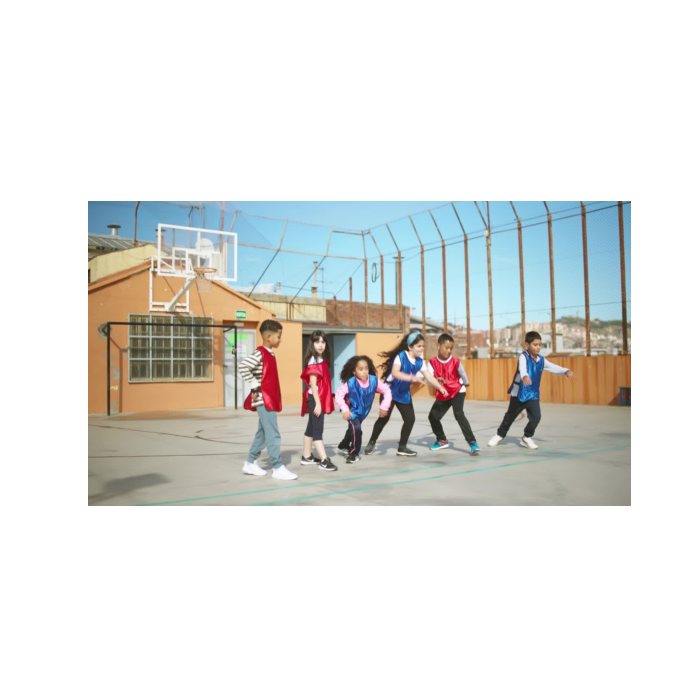

In [5]:
# Interactive UI
points = []
labels = []
last_mask = None
last_low_res = None

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image)
ax.set_axis_off()

mode = widgets.ToggleButtons(
    options=[("Positive", "pos"), ("Negative", "neg")],
    value="pos",
    description="Mode",
)
use_prev_mask = widgets.Checkbox(value=False, description="Use previous mask as input")
run_btn = widgets.Button(description="Run Inference", button_style="success")
undo_btn = widgets.Button(description="Undo Last")
clear_btn = widgets.Button(description="Clear Points")
reset_mask_btn = widgets.Button(description="Reset Mask")
status = widgets.Label(value="Click to add points.")

def _render():
    ax.clear()
    ax.imshow(image)
    if last_mask is not None:
        overlay = np.ma.masked_where(last_mask == 0, last_mask)
        ax.imshow(overlay, cmap="jet", alpha=0.5)
    if points:
        pts = np.array(points)
        labs = np.array(labels)
        pos = pts[labs == 1] if np.any(labs == 1) else np.empty((0, 2))
        neg = pts[labs == 0] if np.any(labs == 0) else np.empty((0, 2))
        if len(pos) > 0:
            ax.scatter(pos[:, 0], pos[:, 1], c="lime", marker="+", s=120, linewidths=2)
        if len(neg) > 0:
            ax.scatter(neg[:, 0], neg[:, 1], c="red", marker="x", s=120, linewidths=2)
    ax.set_axis_off()
    fig.canvas.draw_idle()

def _on_click(event):
    if event.inaxes != ax:
        return
    if event.xdata is None or event.ydata is None:
        return
    label = 1 if mode.value == "pos" else 0
    points.append([event.xdata, event.ydata])
    labels.append(label)
    status.value = f"Points: {len(points)}"
    _render()

def _run_inference(_):
    global last_mask, last_low_res
    if len(points) == 0:
        status.value = "Add at least one point."
        return
    point_coords = np.array(points, dtype=np.float32)
    point_labels = np.array(labels, dtype=np.int32)
    mask_input = None
    if use_prev_mask.value and last_low_res is not None:
        mask_input = last_low_res[None, :, :]
    # For multiple points, a single mask is typically better
    multimask = len(points) == 1
    masks, scores, low_res = model.predict_inst(
        inference_state,
        point_coords=point_coords,
        point_labels=point_labels,
        mask_input=mask_input,
        multimask_output=multimask,
    )
    scores = np.array(scores)
    if scores.ndim == 0:
        scores = scores[None]
    best = int(np.argmax(scores))
    last_mask = masks[best]
    last_low_res = low_res[best]
    status.value = f"Inference done. best score={scores[best]:.3f}"
    _render()

def _undo(_):
    if points:
        points.pop()
        labels.pop()
    status.value = f"Points: {len(points)}"
    _render()

def _clear(_):
    points.clear()
    labels.clear()
    status.value = "Points cleared."
    _render()

def _reset_mask(_):
    global last_mask, last_low_res
    last_mask = None
    last_low_res = None
    status.value = "Mask reset."
    _render()

run_btn.on_click(_run_inference)
undo_btn.on_click(_undo)
clear_btn.on_click(_clear)
reset_mask_btn.on_click(_reset_mask)

cid = fig.canvas.mpl_connect("button_press_event", _on_click)

controls = widgets.HBox([mode, run_btn, undo_btn, clear_btn, reset_mask_btn])
display(controls)
display(use_prev_mask)
display(status)

_render()
